In [1]:
# Library Import
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Custom helper import
from helper.cadplot import conf_matrix
from helper.utils import log_results, plot_training_history,evaluate_model


In [2]:
# Trial run for mini dataset due to processing times.
trail_run = True

In [3]:
# Path Define
# File prefix name
_prefix = ''
_datapath="/Users/taiaburrahman/Desktop/Udg/CADx/Challenge/tf/"
# Set the path to your datasets
if trail_run:
    path = _datapath + "trial_dataset/multiCLASS/"
    _prefix = "trail_"
else:
    path = _datapath + "dataset/multiCLASS/"
    _prefix = "final_"

TRAIN_DATA_DIR = path + 'train'
VALIDATION_DATA_DIR = path + 'val'
TEST_DATA_DIR = path + 'testX'

In [4]:
# Set a random seed for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)


In [5]:
# Helper function

# Save model 
def model_save(model,file_path):
    model.save(file_path)

In [6]:
# Model Param setup
# Image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
# Batch size
batch_size = 32
# Iteration
EPOCHS = 20


In [7]:
# Use ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=90,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2  # 20% of the data will be used for validation
)
# Use ImageDataGenerator for testing without data augmentation
test_datagen = ImageDataGenerator(rescale=1.0/255)
# Create a data generator for training (with validation split)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    subset='training'  # specify that this is the training set
)

# Create a data generator for validation (with validation split)
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    subset='validation'  # specify that this is the validation set
)

test_generator = test_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 123 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 153 images belonging to 3 classes.


In [8]:
prefix = _prefix + 'mm_VGG16'
# Load the pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the convolutional layers of VGG16
for layer in vgg16_model.layers:
    layer.trainable = False

# Create a new model with VGG16 and additional layers for binary classification
vgg16_custom_model = Sequential()
vgg16_custom_model.add(vgg16_model)
vgg16_custom_model.add(Flatten())
vgg16_custom_model.add(Dense(128, activation='relu'))
vgg16_custom_model.add(Dense(1, activation='sigmoid'))

# Model summary
vgg16_custom_model.summary()

# Compile the VGG16 custom model
vgg16_custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the VGG16 custom model
start_time = time.time()

history_vgg16_custom = vgg16_custom_model.fit(
        train_generator, 
        epochs=EPOCHS, 
        validation_data=validation_generator,
    )
end_time = time.time()

# Evaluate the VGG16 custom model on the test set
test_loss_vgg16_custom, test_accuracy_vgg16_custom = vgg16_custom_model.evaluate(test_generator)

# Save the VGG16 custom model (modify the saving path)
model_save(vgg16_custom_model, f'model/{prefix}_model.h5')

2023-12-12 23:14:37.957464: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-12 23:14:37.957519: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-12 23:14:37.957533: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-12 23:14:37.957628: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-12 23:14:37.957663: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17926209 (68.38 MB)
Trainable params: 3211521 (12.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/20


2023-12-12 23:14:39.214761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 4s 979ms/step - loss: 13.9719 - accuracy: 0.4201 - val_loss: 13.6601 - val_accuracy: 0.3333
Epoch 2/20
4/4 [==============================] - 3s 775ms/step - loss: 9.3435 - accuracy: 0.3333 - val_loss: 2.2623 - val_accuracy: 0.3333
Epoch 3/20
4/4 [==============================] - 3s 836ms/step - loss: 1.9924 - accuracy: 0.5854 - val_loss: 3.7329 - val_accuracy: 0.6667
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 4.5890 - accuracy: 0.6667 - val_loss: 5.3580 - val_accuracy: 0.6667
Epoch 5/20
4/4 [==============================] - 4s 1s/step - loss: 5.2623 - accuracy: 0.6667 - val_loss: 4.8343 - val_accuracy: 0.6667
Epoch 6/20
4/4 [==============================] - 5s 1s/step - loss: 4.3240 - accuracy: 0.6667 - val_loss: 3.2223 - val_accuracy: 0.6667
Epoch 7/20
4/4 [==============================] - 4s 830ms/step - loss: 2.3483 - accuracy: 0.6640 - val_loss: 1.0016 - val_accuracy: 0.6333
Epoch 8/20
4/4 [======================

/Users/taiaburrahman/Desktop/Udg/CADx/Challenge/tf/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import numpy as np

# Generate predictions on the test set
y_pred = vgg16_custom_model.predict(test_generator)

# Convert one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_true_labels = test_generator.classes

# Calculate evaluation metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted', zero_division=1)
recall = recall_score(y_true_labels, y_pred_labels, average='weighted', zero_division=1)
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted', zero_division=1)
kappa = cohen_kappa_score(y_true_labels, y_pred_labels)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Cohen\'s Kappa: {kappa:.4f}')

# Print class-wise metrics
print(classification_report(y_true_labels, y_pred_labels))

5/5 [==============================] - 3s 615ms/step
Accuracy: 0.3333
Precision: 0.7778
Recall: 0.3333
F1 Score: 0.1667
Cohen's Kappa: 0.0000
              precision    recall  f1-score   support

           0       0.33      1.00      0.50        51
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        51

    accuracy                           0.33       153
   macro avg       0.11      0.33      0.17       153
weighted avg       0.11      0.33      0.17       153



/Users/taiaburrahman/Desktop/Udg/CADx/Challenge/tf/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/taiaburrahman/Desktop/Udg/CADx/Challenge/tf/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/taiaburrahman/Desktop/Udg/CADx/Challenge/tf/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

5/5 [==============================] - 3s 565ms/step


/Users/taiaburrahman/Desktop/Udg/CADx/Challenge/tf/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/taiaburrahman/Desktop/Udg/CADx/Challenge/tf/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/taiaburrahman/Desktop/Udg/CADx/Challenge/tf/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


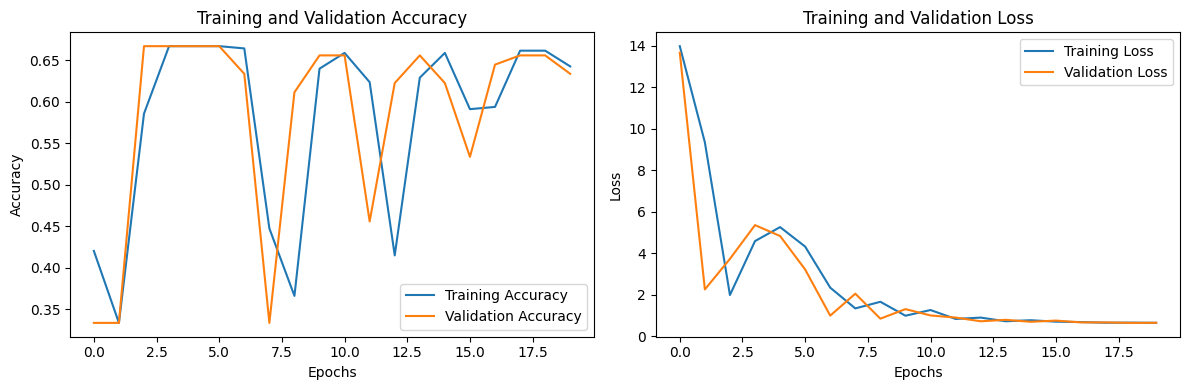

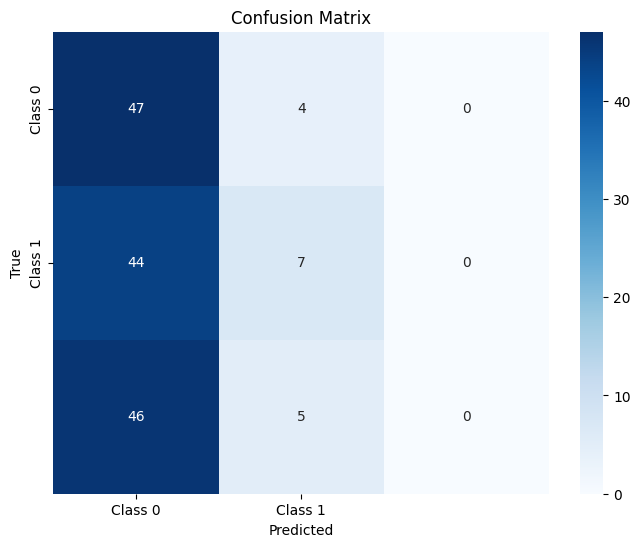

In [10]:
custom_model = vgg16_custom_model
model_history = history_vgg16_custom
# Assuming you have variables vgg16_custom_model and test_generator
test_loss, test_accuracy, conf_mat, classification_rep = evaluate_model(custom_model, test_generator)
# Assuming you have variables like start_time, end_time, test_accuracy, conf_mat, and classification_rep
log_results(prefix, start_time, end_time, test_accuracy, conf_mat, classification_rep)
print(model_history.history.keys())
# Assuming you have a variable model and prefix
plot_training_history(model_history, prefix)
# Create a heatmap for the confusion matrix
conf_matrix(conf_mat)